#### 1 Configuration

## 1.1 Import Libraries

In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy

print("Python ver: {}".format(sys.version))
print("Numpy ver: {}".format(np.__version__))
print("Pandas ver: {}".format(pd.__version__))
print("MatPlotLib ver: {}".format(matplot.__version__))
print("SeaBorn ver: {}".format(sns.__version__))
print("StatsModel ver: {}".format(sm.__version__))
print("Scipy ver: {}".format(scipy.__version__))
print("SkLearn ver: {}".format(sklearn.__version__))

Python ver: 3.9.2 (default, Feb 24 2021, 13:26:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Numpy ver: 1.20.1
Pandas ver: 1.2.2
MatPlotLib ver: 3.3.4
SeaBorn ver: 0.11.1
StatsModel ver: 0.12.2
Scipy ver: 1.6.1
SkLearn ver: 0.24.1


In [2]:
def heatMap(df,max=1,min=-1):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(df, dtype=bool),1)

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df, mask=mask, cmap=cmap, vmax=max, center=(max+min)/2, vmin=min,
                square=True, annot=True, linewidths=.2, cbar_kws={"shrink": .5})

    # Show the plot
    plt.show()
    
def checkCorrectness(df,originalLabel,predictedLabel):
    correct = len(df[(df[originalLabel] == df[predictedLabel])])
    incorrect = len(df) - correct
    return (correct,incorrect,(correct*100/(correct+incorrect)))

def findCorrelatedColumns(df,minThreshold):
    corr = df.corr()
    pairs = []

    for i in corr.columns:
        for j in corr[i][abs(corr[i])>=minThreshold].index:
            if i != j:
                pairs.append({"C1":i,"C2":j,"Corr":corr[i][j]})
    return pairs

def findHighCorrelation(df,minThreshold,target):
    corr = df.corr()
    pairs = []

    for j in corr[target][abs(corr[target])>=minThreshold].index:
        if target != j:
            pairs.append({"Name":j,"Corr":corr[target][j]})
    return pairs

## 1.2 Pre configurations

In [3]:
import warnings

# Set Seaborn theme
sns.set_theme(color_codes=True)

# Disable warnings
warnings.simplefilter("ignore")

# 2 Data Preparation

## 2.1 Load the data

In [4]:
AimoScoreFileUrl = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/AimoScore_WeakLink_big_scores.xls"
WeakLinksFileUrl = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/20190108%20scores_and_weak_links.xlsx"

try:
    AimoScore = pd.read_excel(AimoScoreFileUrl, engine=None)
    WeakLinks = pd.read_excel(WeakLinksFileUrl, engine='openpyxl')

except IOError as e:
    print(e)


## 2.2 Merging the two datasets

### 2.2.1 Join the two tables via their ID

In [5]:
print("AimoScore size: {}".format(len(AimoScore)))
print("WeakLinks size: {}".format(len(WeakLinks)))
result = pd.merge(AimoScore, WeakLinks,on=["ID"])
print("result size: {}".format(len(result)))

AimoScore size: 2094
WeakLinks size: 2096
result size: 2094


### 2.2.2 Find the weakest link for each data point
Finding the column with the maximum score in each row and adding its name as a new column

In [6]:
result["WeakLinks"] = result.loc[:,"ForwardHead":"RightHeelRises"].idxmax(axis=1)

### 2.2.3 Discard extra columns
Discard the 14 weak link scores from the joint table

In [7]:
result.drop(result.columns.to_series()["ForwardHead":"RightHeelRises"], axis=1, inplace=True)

### 2.2.4 Remove Duplicates

In [8]:
result = result.drop_duplicates(subset="ID")

In [9]:
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: WeakLinks, dtype: int64

### 2.2.5 Remove clusters with very few samples 

In [10]:
temp = (result["WeakLinks"].value_counts()<10)
temp = temp[~temp == False]
result = result[~result["WeakLinks"].isin(temp.index)]
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
Name: WeakLinks, dtype: int64

In [11]:
result[["ID","SCORE","AimoScore","WeakLinks"]]

,ID,SCORE,AimoScore,WeakLinks
0,0003cdcc-86ed-494a-a3b5-90d09e96e06b.Kinect,0.323667,0.323667,RightShoulderElevation
1,003115c4-bdb8-491c-b571-8fcebdecf8ed.Kinect,0.323699,0.323699,RightArmFallForward
2,00316bfb-ed43-489f-a55b-11c7f01c852d.Kinect,0.848327,0.848327,LeftArmFallForward
3,00607608-6f2f-459b-a69d-e14067489459.Kinect,0.351332,0.351332,RightShoulderElevation
4,007396ec-3463-4a05-915c-02244ff8d3de.Kinect,0.627181,0.627181,ForwardHead
...,...,...,...,...
2086,feca4c0e-cbc7-4e5e-b85c-8befedbc65a4.Kinect,0.665494,0.665494,RightArmFallForward
2087,fed923af-f41e-42bc-8799-3a9f8a5f2129.Kinect,0.830883,0.830883,LeftArmFallForward
2088,ff015ddd-c9fb-49e3-8e33-abbf72e8b120.Kinect,0.527640,0.527640,LeftArmFallForward
2090,ff514cba-6c5e-41a9-9936-3e8400565c8d.Kinect,0.407197,0.407197,RightKneeMovesOutward


## 2.3 Removing the identical variables

In [12]:
pairs = findCorrelatedColumns(result,1)
pairs

[{'C1': 'AimoScore', 'C2': 'SCORE', 'Corr': 1.0},
 {'C1': 'No_1_Angle_Deviation', 'C2': 'No_3_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_5_Angle_Deviation', 'C2': 'No_1_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_7_Angle_Deviation', 'C2': 'No_2_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_10_Angle_Deviation', 'C2': 'No_4_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_13_Angle_Deviation', 'C2': 'No_5_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_1_NASM_Deviation', 'C2': 'No_5_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_2_NASM_Deviation', 'C2': 'No_7_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_3_NASM_Deviation', 'C2': 'No_1_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_4_NASM_Deviation', 'C2': 'No_10_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_5_NASM_Deviation', 'C2': 'No_13_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'SCORE', 'C2': 'AimoScore', 'Corr': 1.0}]

In [13]:
result = result.drop(
    columns=[
        "No_1_Angle_Deviation",
        "No_5_Angle_Deviation",
        "No_7_Angle_Deviation",
        "No_10_Angle_Deviation",
        "No_13_Angle_Deviation",
        "SCORE"
    ]
)

## 2.4 Removing the symmetric variables 
We assume that any variable with a correlation higher than 80 percent would be a symmetric variable

In [14]:
pairs = findCorrelatedColumns(result,0.8)
pairs

[{'C1': 'No_1_NASM_Deviation',
  'C2': 'No_2_NASM_Deviation',
  'Corr': 0.8491413141954612},
 {'C1': 'No_2_NASM_Deviation',
  'C2': 'No_1_NASM_Deviation',
  'Corr': 0.8491413141954612},
 {'C1': 'No_4_NASM_Deviation',
  'C2': 'No_5_NASM_Deviation',
  'Corr': 0.9045936446980892},
 {'C1': 'No_5_NASM_Deviation',
  'C2': 'No_4_NASM_Deviation',
  'Corr': 0.9045936446980892},
 {'C1': 'No_8_NASM_Deviation',
  'C2': 'No_9_NASM_Deviation',
  'Corr': 0.8742235883032177},
 {'C1': 'No_9_NASM_Deviation',
  'C2': 'No_8_NASM_Deviation',
  'Corr': 0.8742235883032177},
 {'C1': 'No_11_NASM_Deviation',
  'C2': 'No_12_NASM_Deviation',
  'Corr': 0.8645293700913517},
 {'C1': 'No_12_NASM_Deviation',
  'C2': 'No_11_NASM_Deviation',
  'Corr': 0.8645293700913517},
 {'C1': 'No_1_Time_Deviation',
  'C2': 'No_2_Time_Deviation',
  'Corr': 0.9390442066679051},
 {'C1': 'No_2_Time_Deviation',
  'C2': 'No_1_Time_Deviation',
  'Corr': 0.9390442066679051}]

In [15]:
result = result.drop(
    columns=[
        "No_1_NASM_Deviation",
        "No_5_NASM_Deviation",
        "No_9_NASM_Deviation",
        "No_11_NASM_Deviation",
        "No_2_Time_Deviation"
    ]
)

## 2.5 Discard extra columns

In [16]:
result = result.drop(
    columns=[
        "ID",
        "Date",
        "EstimatedScore"
    ]
)

### Testing and Traing sets

In [17]:
from sklearn.model_selection import train_test_split

trainingPercent = 0.8

y_train,y_test ,X_train, X_test  = train_test_split(result[["WeakLinks","AimoScore"]], result.drop(columns=["WeakLinks","AimoScore"]), train_size = trainingPercent)

# 3 Create the linear model

## 3.1  Check with 10-Fold Cross-Validation

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

minCorrelationSteps = [0.4,0.3,0.2,0.1,0]

# Using 10-fold cross-validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 1)
cvResults = pd.DataFrame()
y = y_train["AimoScore"]

for minCorrelation in minCorrelationSteps:
    print(minCorrelation)
    columns = []
    for i in findHighCorrelation(result.drop(columns=["WeakLinks"]),minCorrelation,"AimoScore"):
        columns.append(i["Name"])

    X = X_train[columns]
    errors = []
    for i in range(0, 4):
        pipe = make_pipeline(PolynomialFeatures(degree = i),LinearRegression())
        cv_scores = cross_val_score(pipe, X, y, scoring = "neg_mean_squared_error", cv = kfolds)
        errors.append(abs(cv_scores.mean()))
        
    cvResults[minCorrelation] = errors


0.4
0.3
0.2
0.1
0


In [19]:
cvResults

,0.4,0.3,0.2,0.1,0.0
0,NaN,NaN,NaN,NaN,NaN
1,0.034282,0.029976,0.026267,0.025227,0.024914
2,0.030104,0.026389,0.022680,0.022710,0.025674
3,0.028954,0.026453,0.814255,0.078245,0.065962


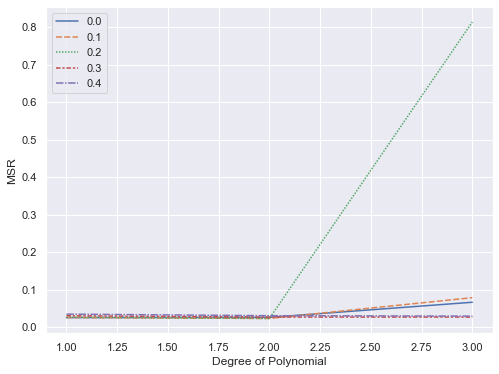

In [20]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(data=cvResults,ax=ax)

# Add labels to plot
plt.xlabel("Degree of Polynomial")
plt.ylabel("MSR")

plt.show()

## 3.2 A new Candidate 
we choose all possible predictors that have more than 20% corelation with AimoScore and have used a 3 degree of polynomial regression model

In [21]:
findHighCorrelation(result.drop(columns=["WeakLinks"]),0.25,"AimoScore")

[{'Name': 'No_6_Angle_Deviation', 'Corr': -0.309230620053922},
 {'Name': 'No_8_Angle_Deviation', 'Corr': -0.3082475278498865},
 {'Name': 'No_11_Angle_Deviation', 'Corr': -0.30371898755134086},
 {'Name': 'No_12_Angle_Deviation', 'Corr': -0.3255914885172601},
 {'Name': 'No_4_NASM_Deviation', 'Corr': -0.37531756282201933},
 {'Name': 'No_10_NASM_Deviation', 'Corr': -0.4174122643443289},
 {'Name': 'No_12_NASM_Deviation', 'Corr': -0.48783980176611097},
 {'Name': 'No_17_NASM_Deviation', 'Corr': -0.26339714917816237},
 {'Name': 'No_22_NASM_Deviation', 'Corr': -0.257542545683615}]

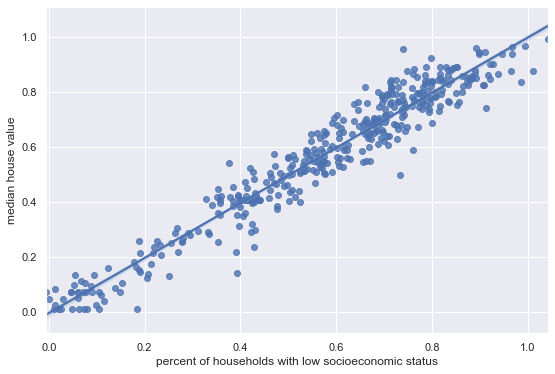

r = 0.968 , p < 9.126073822295734e-251


In [22]:
minCorrelation = 0.2

y = result["AimoScore"]
columns = []

for i in findHighCorrelation(result.drop(columns=["WeakLinks"]),minCorrelation,"AimoScore"):
        columns.append(i["Name"])
        
X_0 = result[columns]

pipe = make_pipeline(PolynomialFeatures(3),LinearRegression())
polyreg = pipe.fit(X_0, y)
predicted_0 = polyreg.predict(X_test[columns])


res = pd.DataFrame({"Original":y_test["AimoScore"],"Predicted":predicted_0})


fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("percent of households with low socioeconomic status")
plt.ylabel("median house value")
plt.show()
r,p = scipy.stats.pearsonr(res.Predicted, res.Original)
print("r = {} , p < {}".format(round(r, 3),p))

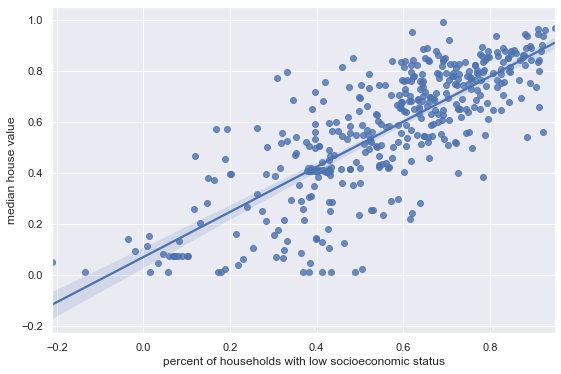

r = 0.788 , p < 2.7059162266097e-89


In [23]:
minCorrelation = 0.1

#y = result["AimoScore"]
y = y_train["AimoScore"]

columns = []

for i in findHighCorrelation(result.drop(columns=["WeakLinks"]),minCorrelation,"AimoScore"):
        columns.append(i["Name"])
        
#X_1 = result[columns]
X_1 = X_train[columns]

pipe = make_pipeline(PolynomialFeatures(2),LinearRegression())
polyreg = pipe.fit(X_1, y)
predicted_1 = polyreg.predict(X_test[columns])


res = pd.DataFrame({"Original":y_test["AimoScore"],"Predicted":predicted_1})


fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("percent of households with low socioeconomic status")
plt.ylabel("median house value")
plt.show()
r,p = scipy.stats.pearsonr(res.Predicted, res.Original)
print("r = {} , p < {}".format(round(r, 3),p))

## 3.3 The original model
This is our previous linear model with adjusted r-squared of 0.705

In [24]:
def createExtraPredictors(df):
    X_3 = df.drop(columns=[])
    X_3["A4*N12"] = X_3["No_4_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["A8*N12"] = X_3["No_8_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N2*N20"] = X_3["No_2_NASM_Deviation"] * X_3["No_20_NASM_Deviation"]
    X_3["N12*N13"] = X_3["No_12_NASM_Deviation"] * X_3["No_13_NASM_Deviation"]
    X_3["N12*N15"] = X_3["No_12_NASM_Deviation"] * X_3["No_15_NASM_Deviation"]
    X_3["N12*N16"] = X_3["No_12_NASM_Deviation"] * X_3["No_16_NASM_Deviation"]
    X_3["N12*N20"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"]
    X_3["N12*N20*N22"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_22_NASM_Deviation"]
    X_3["N12*N20*N19"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_19_NASM_Deviation"]
    X_3["N12*N20*N19*N16"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_19_NASM_Deviation"]* X_3["No_16_NASM_Deviation"]
    X_3["N12*N23"] = X_3["No_12_NASM_Deviation"] * X_3["No_23_NASM_Deviation"]
    X_3["N21*N24"] = X_3["No_21_NASM_Deviation"] * X_3["No_24_NASM_Deviation"]
    X_3["T1*N13"] = X_3["No_1_Time_Deviation"] * X_3["No_13_NASM_Deviation"]
    X_3["T1*N2"] = X_3["No_1_Time_Deviation"] * X_3["No_2_Angle_Deviation"]
    X_3["T1*N18"] = X_3["No_1_Time_Deviation"] * X_3["No_18_NASM_Deviation"]
    X_3["N4*N10*N12"] = X_3["No_4_NASM_Deviation"] * X_3["No_10_NASM_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N8*N12"] = X_3["No_8_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N4*N10*N12*N15"] = X_3["No_4_NASM_Deviation"] * X_3["No_10_NASM_Deviation"] * X_3["No_12_NASM_Deviation"] * X_3["No_15_NASM_Deviation"]
    X_3["A11*N12"] = X_3["No_11_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N8*N15"] = X_3["No_8_NASM_Deviation"] * X_3["No_15_NASM_Deviation"]
    X_3["N15*N20"] = X_3["No_15_NASM_Deviation"] * X_3["No_20_NASM_Deviation"]
    X_3["N14*N15*N20*N21"] = X_3["No_14_NASM_Deviation"] *X_3["No_15_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_21_NASM_Deviation"]
    X_3["N4*N10"] = X_3["No_4_NASM_Deviation"] * X_3["No_10_NASM_Deviation"]
    X_3["N4**2"] = X_3["No_4_NASM_Deviation"] ** 2
    X_3["N8**2"] = X_3["No_8_NASM_Deviation"] ** 2
    X_3["N10**2"] = X_3["No_10_NASM_Deviation"] ** 2
    X_3["N10**3"] = X_3["No_10_NASM_Deviation"] ** 3
    X_3["N8**"] = X_3["No_8_NASM_Deviation"] ** 3
    X_3["N8**4"] = X_3["No_8_NASM_Deviation"] ** 4
    X_3["N8**5"] = X_3["No_8_NASM_Deviation"] ** 5
    X_3["N4*N14"] = X_3["No_4_NASM_Deviation"] * X_3["No_14_NASM_Deviation"]
    X_3["N20*N24"] = X_3["No_20_NASM_Deviation"] * X_3["No_24_NASM_Deviation"]
    X_3["N21*N23"] = X_3["No_21_NASM_Deviation"] * X_3["No_23_NASM_Deviation"]
    X_3["T1*N21*N23"] = X_3["No_1_Time_Deviation"] * X_3["N21*N23"]
    X_3["T1*N21*N23*N12"] = X_3["No_1_Time_Deviation"] * X_3["N21*N23"] * X_3["No_12_NASM_Deviation"]
    X_3["T1*N21*N23*N2*N4"] = X_3["No_1_Time_Deviation"] * X_3["N21*N23"]*X_3["No_2_NASM_Deviation"] * X_3["No_4_NASM_Deviation"]
    X_3["N20*N16"] = X_3["No_20_NASM_Deviation"] * X_3["No_16_NASM_Deviation"]
    X_3["N20*N16*N19"] = X_3["No_20_NASM_Deviation"] * X_3["No_16_NASM_Deviation"] * X_3["No_19_NASM_Deviation"]
    X_3["N12*N6"] = X_3["No_12_NASM_Deviation"] * X_3["No_6_NASM_Deviation"]
    X_3["N12*N7"] = X_3["No_12_NASM_Deviation"] * X_3["No_7_NASM_Deviation"]
    X_3["N12**2"] = X_3["No_12_NASM_Deviation"] ** 2
    X_3["N12**3"] = X_3["No_12_NASM_Deviation"] ** 3
    X_3["N12**4"] = X_3["No_12_NASM_Deviation"] ** 4
    X_3["N12**5"] = X_3["No_12_NASM_Deviation"] ** 5
    X_3["N12**6"] = X_3["No_12_NASM_Deviation"] ** 6
    X_3["N15**3"] = X_3["No_15_NASM_Deviation"] **3
    X_3["N20**3"] = X_3["No_20_NASM_Deviation"] **3

    return X_3.drop(columns=[
        "No_4_Angle_Deviation",
        "No_14_NASM_Deviation",
        "No_4_NASM_Deviation",
        "No_21_NASM_Deviation",
        "No_24_NASM_Deviation",
        "No_25_NASM_Deviation",
        "No_10_NASM_Deviation",
        "No_13_NASM_Deviation"
    ])

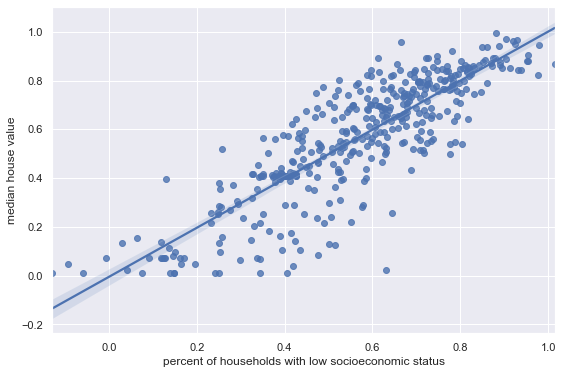

r = 0.848 , p < 1.16686180194943e-116


In [25]:
y = y_train["AimoScore"]
X_2 = createExtraPredictors(X_train)

t = sm.add_constant(X_2, prepend=False)
model = sm.OLS(y,t).fit()

yt = y_test["AimoScore"]
X_3 = createExtraPredictors(X_test)

t1 = sm.add_constant(X_3, prepend=False)
predicted_2 = model.predict(t1)

res = pd.DataFrame({"Original":yt,"Predicted":predicted_2})

fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("percent of households with low socioeconomic status")
plt.ylabel("median house value")
plt.show()
r,p = scipy.stats.pearsonr(res.Predicted, res.Original)
print("r = {} , p < {}".format(round(r, 3),p))

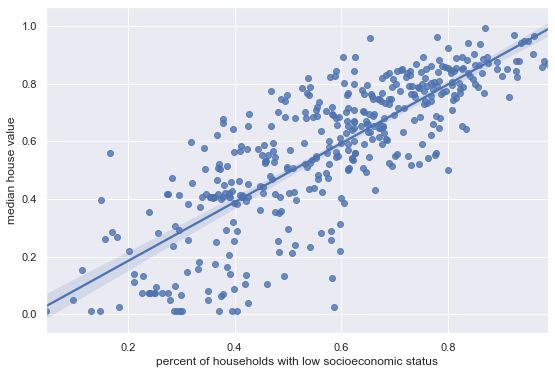

r = 0.808 , p < 1.829964021198728e-97


In [26]:
y = y_train["AimoScore"]
X_2 = X_train.drop(columns=[])
X_2["No_12_NASM_Deviation ^ 2"] = X_2["No_12_NASM_Deviation"] ** 2


t = sm.add_constant(X_2, prepend=False)
model = sm.OLS(y,t).fit()

yt = y_test["AimoScore"]
X_3 = X_test.drop(columns=[])
X_3["No_12_NASM_Deviation ^ 2"] = X_3["No_12_NASM_Deviation"] ** 2


t1 = sm.add_constant(X_3, prepend=False)
predicted_3 = model.predict(t1)

res = pd.DataFrame({"Original":yt,"Predicted":predicted_3})

fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("percent of households with low socioeconomic status")
plt.ylabel("median house value")
plt.show()
r,p = scipy.stats.pearsonr(res.Predicted, res.Original)
print("r = {} , p < {}".format(round(r, 3),p))

## 3.4 Comparison

### 3.4.1 Comparing the MSRs 

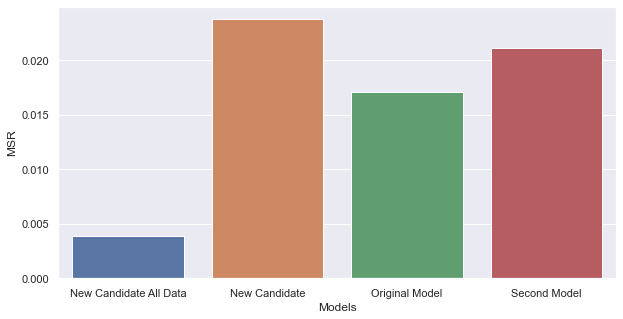

In [27]:
from sklearn.metrics import mean_squared_error

mse_0 = mean_squared_error(yt, predicted_0)
mse_1 = mean_squared_error(yt, predicted_1)
mse_2 = mean_squared_error(yt, predicted_2)
mse_3 = mean_squared_error(yt, predicted_3)


results = pd.DataFrame({"MSR":[mse_0,mse_1,mse_2,mse_3],"Models":["New Candidate All Data","New Candidate","Original Model","Second Model"]})

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(data=results, x="Models", y="MSR",ax=ax)

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("MSR")

plt.show()

Considering result it seems the new candidate with all data would be the best, but when we train it with 80% and predict with other 20% the result will be the worst which is sign of overfitting problem. so we consider useing our original model wich has the best outcome when we use diffrent sets for training and testing and even with 20% of data as the traing data its prediction is better than the others

# 4 Create the Clustring Model

## 4.1 Logistic regression

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

minCorrelationSteps = [0.1,0]

# Using 10-fold cross-validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 1)
cvResults = pd.DataFrame()
y = y_train["WeakLinks"]

for minCorrelation in minCorrelationSteps:
    print(minCorrelation)
    columns = []
    for i in findHighCorrelation(result.drop(columns=["WeakLinks"]),minCorrelation,"AimoScore"):
        columns.append(i["Name"])

    X = X_train[columns]
    errors = []
    for i in range(1, 30):
        model_3 = LogisticRegression(solver='liblinear', C=i, random_state=0)
        cv_scores = cross_val_score(model_3, X, y, scoring='accuracy', cv = kfolds)
        errors.append(abs(cv_scores.mean()))
        
    cvResults[minCorrelation] = errors
    

0.1
0


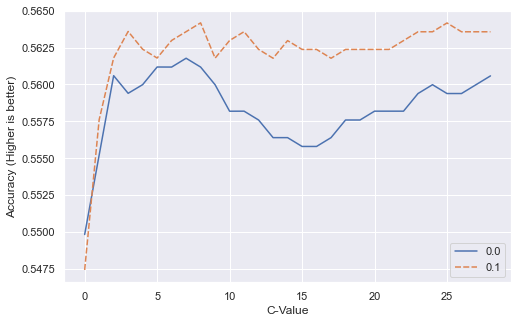

In [29]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=cvResults,ax=ax)

# Add labels to plot
plt.xlabel("C-Value")
plt.ylabel("Accuracy (Higher is better)")

plt.show()

## 4.2 K-Nearest Neighbors Clustering

In [30]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

minCorrelationSteps = [0.1,0]

# Using 10-fold cross-validation
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 1)
cvResults = pd.DataFrame()
y = y_train["WeakLinks"]

for minCorrelation in minCorrelationSteps:
    print(minCorrelation)
    columns = []
    for i in findHighCorrelation(result.drop(columns=["WeakLinks"]),minCorrelation,"AimoScore"):
        columns.append(i["Name"])

    X = X_train[columns]
    errors = []
    for i in range(1, 30):
        model_4 = neighbors.KNeighborsClassifier(n_neighbors=i)
        cv_scores = cross_val_score(model_4, X, y, scoring='accuracy', cv = kfolds)
        errors.append(abs(cv_scores.mean()))
        
    cvResults[minCorrelation] = errors

0.1
0


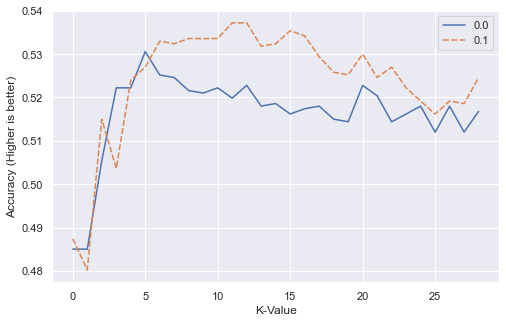

In [31]:
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=cvResults,ax=ax)

# Add labels to plot
plt.xlabel("K-Value")
plt.ylabel("Accuracy (Higher is better)")
plt.show()

## 4.3 Candidates

### 4.3.1 Logistic regression C=18

In [32]:
from sklearn.linear_model import LogisticRegression

columns = []
for i in findHighCorrelation(result.drop(columns=["WeakLinks"]),0.1,"AimoScore"):
    columns.append(i["Name"])

X = X_train[columns]

model_4 = LogisticRegression(solver='liblinear', C=18, random_state=0)
result_4 = model_4.fit(X, y_train["WeakLinks"])

prob = result_4.predict_proba(X_test[columns])

# Find maximum value from probability prediction array
maxValues = pd.DataFrame(prob, columns = range(0,11))

# Dominant WeakLink
dominant = result_4.classes_[maxValues.idxmax(axis=1, skipna=True)]

comparison = pd.DataFrame({'Original': y_test["WeakLinks"], 'Dominant':dominant})

print(classification_report(y_test["WeakLinks"], dominant, digits=3))
accuracy_1 = classification_report(y_test["WeakLinks"], dominant, digits=3,output_dict=True)["accuracy"]

print("Predictors: ",columns)

                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.750     0.652     0.698        23
                 ForwardHead      0.560     0.609     0.583        23
          LeftArmFallForward      0.545     0.667     0.600       117
 LeftAsymmetricalWeightShift      0.692     0.692     0.692        13
        LeftKneeMovesOutward      0.500     0.167     0.250        12
       LeftShoulderElevation      0.333     0.182     0.235        11
         RightArmFallForward      0.489     0.430     0.457       100
RightAsymmetricalWeightShift      0.000     0.000     0.000         8
        RightKneeMovesInward      0.000     0.000     0.000         5
       RightKneeMovesOutward      0.873     0.941     0.906        51
      RightShoulderElevation      0.565     0.648     0.603        54

                    accuracy                          0.590       417
                   macro avg      0.482     0.453     0.457       417
                we

### 4.3.2 K-Nearest Neighbors Clustering K=14

In [33]:
from sklearn import neighbors
from sklearn.metrics import confusion_matrix,classification_report

model_5 = neighbors.KNeighborsClassifier(n_neighbors=14)
result_5 = model_5.fit(X_train, y_train["WeakLinks"])
y_pred = result_5.predict(X_test)

comparison = pd.DataFrame({'Original': y_test["WeakLinks"],'Predicted': y_pred})
confusion_matrix = comparison.groupby(['Predicted','Original']).size().unstack('Original').fillna(0)

print(classification_report(y_test["WeakLinks"], y_pred, digits=3))
accuracy_2 = classification_report(y_test["WeakLinks"], y_pred, digits=3,output_dict=True)["accuracy"]

                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.407     0.478     0.440        23
                 ForwardHead      0.611     0.478     0.537        23
          LeftArmFallForward      0.470     0.667     0.551       117
 LeftAsymmetricalWeightShift      0.462     0.462     0.462        13
        LeftKneeMovesOutward      0.000     0.000     0.000        12
       LeftShoulderElevation      0.000     0.000     0.000        11
         RightArmFallForward      0.483     0.420     0.449       100
RightAsymmetricalWeightShift      0.000     0.000     0.000         8
        RightKneeMovesInward      0.000     0.000     0.000         5
       RightKneeMovesOutward      0.885     0.902     0.893        51
      RightShoulderElevation      0.538     0.519     0.528        54

                    accuracy                          0.532       417
                   macro avg      0.351     0.357     0.351       417
                we

## 4.4 The Original Model

In [34]:
from sklearn.linear_model import LogisticRegression

model_6 = LogisticRegression(solver='liblinear', C=25.0, random_state=0)
result_6 = model_6.fit(X_train, y_train["WeakLinks"])

prob = result_6.predict_proba(X_test)

# Find maximum value from probability prediction array
maxValues = pd.DataFrame(prob, columns = range(0,11))

# Dominant WeakLink
dominant = result_6.classes_[maxValues.idxmax(axis=1, skipna=True)]

comparison = pd.DataFrame({'Original': y_test["WeakLinks"], 'Dominant':dominant})

print(classification_report(y_test["WeakLinks"], dominant, digits=3))
accuracy_3 = classification_report(y_test["WeakLinks"], dominant, digits=3,output_dict=True)["accuracy"]

                              precision    recall  f1-score   support

        ExcessiveForwardLean      0.727     0.696     0.711        23
                 ForwardHead      0.583     0.609     0.596        23
          LeftArmFallForward      0.555     0.692     0.616       117
 LeftAsymmetricalWeightShift      0.667     0.615     0.640        13
        LeftKneeMovesOutward      0.667     0.333     0.444        12
       LeftShoulderElevation      0.400     0.182     0.250        11
         RightArmFallForward      0.494     0.420     0.454       100
RightAsymmetricalWeightShift      0.333     0.125     0.182         8
        RightKneeMovesInward      0.000     0.000     0.000         5
       RightKneeMovesOutward      0.889     0.941     0.914        51
      RightShoulderElevation      0.583     0.648     0.614        54

                    accuracy                          0.602       417
                   macro avg      0.536     0.478     0.493       417
                we

## 4.5 Comparison

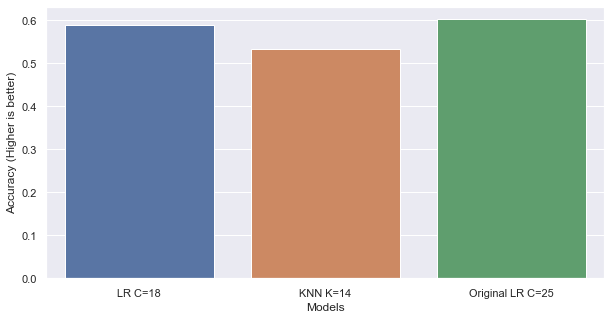

In [35]:
results = pd.DataFrame({"Accuracy":[accuracy_1,accuracy_2,accuracy_3],"Models":["LR C=18","KNN K=14","Original LR C=25"]})

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(data=results, x="Models", y="Accuracy",ax=ax)

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("Accuracy (Higher is better)")

plt.show()

According to the result the logestic regression with 28 Predictors and C=18 is slighty better model than the original one. However, KNN with K=14 is slightly weaker than our orginal logistic regression. Therefor, the logestic regression (C=18) with following predictors will be our new champion.

Predictors are:
   - No_3_Angle_Deviation
   - No_4_Angle_Deviation
   - No_6_Angle_Deviation
   - No_8_Angle_Deviation
   - No_9_Angle_Deviation
   - No_11_Angle_Deviation
   - No_12_Angle_Deviation
   - No_2_NASM_Deviation
   - No_3_NASM_Deviation
   - No_4_NASM_Deviation
   - No_6_NASM_Deviation
   - No_7_NASM_Deviation
   - No_8_NASM_Deviation
   - No_10_NASM_Deviation
   - No_12_NASM_Deviation
   - No_14_NASM_Deviation
   - No_16_NASM_Deviation
   - No_17_NASM_Deviation
   - No_18_NASM_Deviation
   - No_19_NASM_Deviation
   - No_20_NASM_Deviation
   - No_21_NASM_Deviation
   - No_22_NASM_Deviation
   - No_23_NASM_Deviation
   - No_24_NASM_Deviation
   - No_25_NASM_Deviation
   - No_1_Time_Deviation

# Classfier

### Data prepration

In [36]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import graphviz

In [37]:
result

,AimoScore,No_2_Angle_Deviation,No_3_Angle_Deviation,No_4_Angle_Deviation,No_6_Angle_Deviation,No_8_Angle_Deviation,No_9_Angle_Deviation,No_11_Angle_Deviation,No_12_Angle_Deviation,No_2_NASM_Deviation,...,No_18_NASM_Deviation,No_19_NASM_Deviation,No_20_NASM_Deviation,No_21_NASM_Deviation,No_22_NASM_Deviation,No_23_NASM_Deviation,No_24_NASM_Deviation,No_25_NASM_Deviation,No_1_Time_Deviation,WeakLinks
0,0.323667,0.815878,0.346724,0.382114,0.947872,0.521760,0.457198,0.835007,0.451937,0.275945,...,0.587757,0.833094,0.656624,0.642276,0.552846,0.648972,0.578192,0.560019,0.821616,RightShoulderElevation
1,0.323699,0.306552,0.823529,0.188905,0.140124,0.521760,0.729316,0.635581,0.222382,0.664275,...,0.441416,0.670971,0.721186,0.826399,0.805356,0.848876,0.889048,0.816834,0.307987,RightArmFallForward
2,0.848327,0.373984,0.346724,0.590626,0.298900,0.623625,0.658058,0.635581,0.957915,0.276901,...,0.733142,0.670971,0.656624,0.642276,0.690579,0.648972,0.578192,0.555715,0.218556,LeftArmFallForward
3,0.351332,0.623625,0.380201,0.975132,0.888570,0.847441,0.237207,0.846485,0.431851,0.363462,...,0.934003,0.953611,0.656624,0.642276,0.552846,0.648972,0.578192,0.744620,0.458154,RightShoulderElevation
4,0.627181,0.657580,0.745576,0.552846,0.483022,0.521760,0.387853,0.635581,0.095170,0.388331,...,0.441416,0.670971,0.656624,0.642276,0.552846,0.648972,0.578192,0.308943,0.805356,ForwardHead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,0.665494,0.396939,0.786705,0.646581,0.140124,0.521760,0.354376,0.635581,0.449067,0.690579,...,0.441416,0.670971,0.656624,0.933046,0.890483,0.795313,0.578192,0.815878,0.150167,RightArmFallForward
2087,0.830883,0.900526,0.628886,0.414634,0.224773,0.521760,0.156385,0.635581,0.345768,0.516978,...,0.441416,0.670971,0.656624,0.642276,0.552846,0.667145,0.578192,0.308943,0.148733,LeftArmFallForward
2088,0.527640,0.193687,0.780488,0.956958,0.912482,0.632233,0.708274,0.774749,0.398852,0.630799,...,0.984218,0.988522,0.656624,0.642276,0.552846,0.648972,0.578192,0.736011,0.764706,LeftArmFallForward
2090,0.407197,0.131038,0.346724,0.317073,0.646581,0.521760,0.570540,0.635581,0.851746,0.913439,...,0.789574,0.670971,0.945002,0.642276,0.596365,0.648972,0.749880,0.943568,0.684840,RightKneeMovesOutward


In [38]:
dtc_result = result.drop(['AimoScore'], axis=1)

In [39]:
print(dtc_result['WeakLinks'].value_counts(), end="\n\n")

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
Name: WeakLinks, dtype: int64



In [40]:
dtc_result['WeakLinks'] = dtc_result.WeakLinks.map({'LeftArmFallForward':0, 'RightArmFallForward':1, 'RightKneeMovesOutward':2, 'RightShoulderElevation':3, 'ForwardHead':4, 'ExcessiveForwardLean':5, 'LeftAsymmetricalWeightShift':6, 'LeftShoulderElevation':7, 'LeftKneeMovesOutward':8, 'RightKneeMovesInward':9, 'RightAsymmetricalWeightShift':10})

In [41]:
dtc_result

,No_2_Angle_Deviation,No_3_Angle_Deviation,No_4_Angle_Deviation,No_6_Angle_Deviation,No_8_Angle_Deviation,No_9_Angle_Deviation,No_11_Angle_Deviation,No_12_Angle_Deviation,No_2_NASM_Deviation,No_3_NASM_Deviation,...,No_18_NASM_Deviation,No_19_NASM_Deviation,No_20_NASM_Deviation,No_21_NASM_Deviation,No_22_NASM_Deviation,No_23_NASM_Deviation,No_24_NASM_Deviation,No_25_NASM_Deviation,No_1_Time_Deviation,WeakLinks
0,0.815878,0.346724,0.382114,0.947872,0.521760,0.457198,0.835007,0.451937,0.275945,0.538020,...,0.587757,0.833094,0.656624,0.642276,0.552846,0.648972,0.578192,0.560019,0.821616,3
1,0.306552,0.823529,0.188905,0.140124,0.521760,0.729316,0.635581,0.222382,0.664275,0.443807,...,0.441416,0.670971,0.721186,0.826399,0.805356,0.848876,0.889048,0.816834,0.307987,1
2,0.373984,0.346724,0.590626,0.298900,0.623625,0.658058,0.635581,0.957915,0.276901,0.603539,...,0.733142,0.670971,0.656624,0.642276,0.690579,0.648972,0.578192,0.555715,0.218556,0
3,0.623625,0.380201,0.975132,0.888570,0.847441,0.237207,0.846485,0.431851,0.363462,0.484935,...,0.934003,0.953611,0.656624,0.642276,0.552846,0.648972,0.578192,0.744620,0.458154,3
4,0.657580,0.745576,0.552846,0.483022,0.521760,0.387853,0.635581,0.095170,0.388331,0.860832,...,0.441416,0.670971,0.656624,0.642276,0.552846,0.648972,0.578192,0.308943,0.805356,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,0.396939,0.786705,0.646581,0.140124,0.521760,0.354376,0.635581,0.449067,0.690579,0.576279,...,0.441416,0.670971,0.656624,0.933046,0.890483,0.795313,0.578192,0.815878,0.150167,1
2087,0.900526,0.628886,0.414634,0.224773,0.521760,0.156385,0.635581,0.345768,0.516978,0.788140,...,0.441416,0.670971,0.656624,0.642276,0.552846,0.667145,0.578192,0.308943,0.148733,0
2088,0.193687,0.780488,0.956958,0.912482,0.632233,0.708274,0.774749,0.398852,0.630799,0.575323,...,0.984218,0.988522,0.656624,0.642276,0.552846,0.648972,0.578192,0.736011,0.764706,0
2090,0.131038,0.346724,0.317073,0.646581,0.521760,0.570540,0.635581,0.851746,0.913439,0.279770,...,0.789574,0.670971,0.945002,0.642276,0.596365,0.648972,0.749880,0.943568,0.684840,2


In [42]:
x_1 = dtc_result.drop(['WeakLinks'], axis=1)
y_1 = dtc_result['WeakLinks']
y_1

0       3
1       1
2       0
3       3
4       4
       ..
2086    1
2087    0
2088    0
2090    2
2092    0
Name: WeakLinks, Length: 2085, dtype: int64

In [43]:
dtc_one = DecisionTreeClassifier()
dtc_one.fit(x_1, y_1)

DecisionTreeClassifier()

In [44]:
x_1.columns

Index(['No_2_Angle_Deviation', 'No_3_Angle_Deviation', 'No_4_Angle_Deviation',
       'No_6_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation',
       'No_11_Angle_Deviation', 'No_12_Angle_Deviation', 'No_2_NASM_Deviation',
       'No_3_NASM_Deviation', 'No_4_NASM_Deviation', 'No_6_NASM_Deviation',
       'No_7_NASM_Deviation', 'No_8_NASM_Deviation', 'No_10_NASM_Deviation',
       'No_12_NASM_Deviation', 'No_13_NASM_Deviation', 'No_14_NASM_Deviation',
       'No_15_NASM_Deviation', 'No_16_NASM_Deviation', 'No_17_NASM_Deviation',
       'No_18_NASM_Deviation', 'No_19_NASM_Deviation', 'No_20_NASM_Deviation',
       'No_21_NASM_Deviation', 'No_22_NASM_Deviation', 'No_23_NASM_Deviation',
       'No_24_NASM_Deviation', 'No_25_NASM_Deviation', 'No_1_Time_Deviation'],
      dtype='object')

In [45]:
#feature and class names

feature_names = x_1.columns
class_names = ['LeftArmFallForward', 'RightArmFallForward', 'RightKneeMovesOutward', 'RightShoulderElevation', 'ForwardHead', 'ExcessiveForwardLean', 'LeftAsymmetricalWeightShift', 'LeftShoulderElevation', 'LeftKneeMovesOutward', 'RightKneeMovesInward', 'RightAsymmetricalWeightShift']

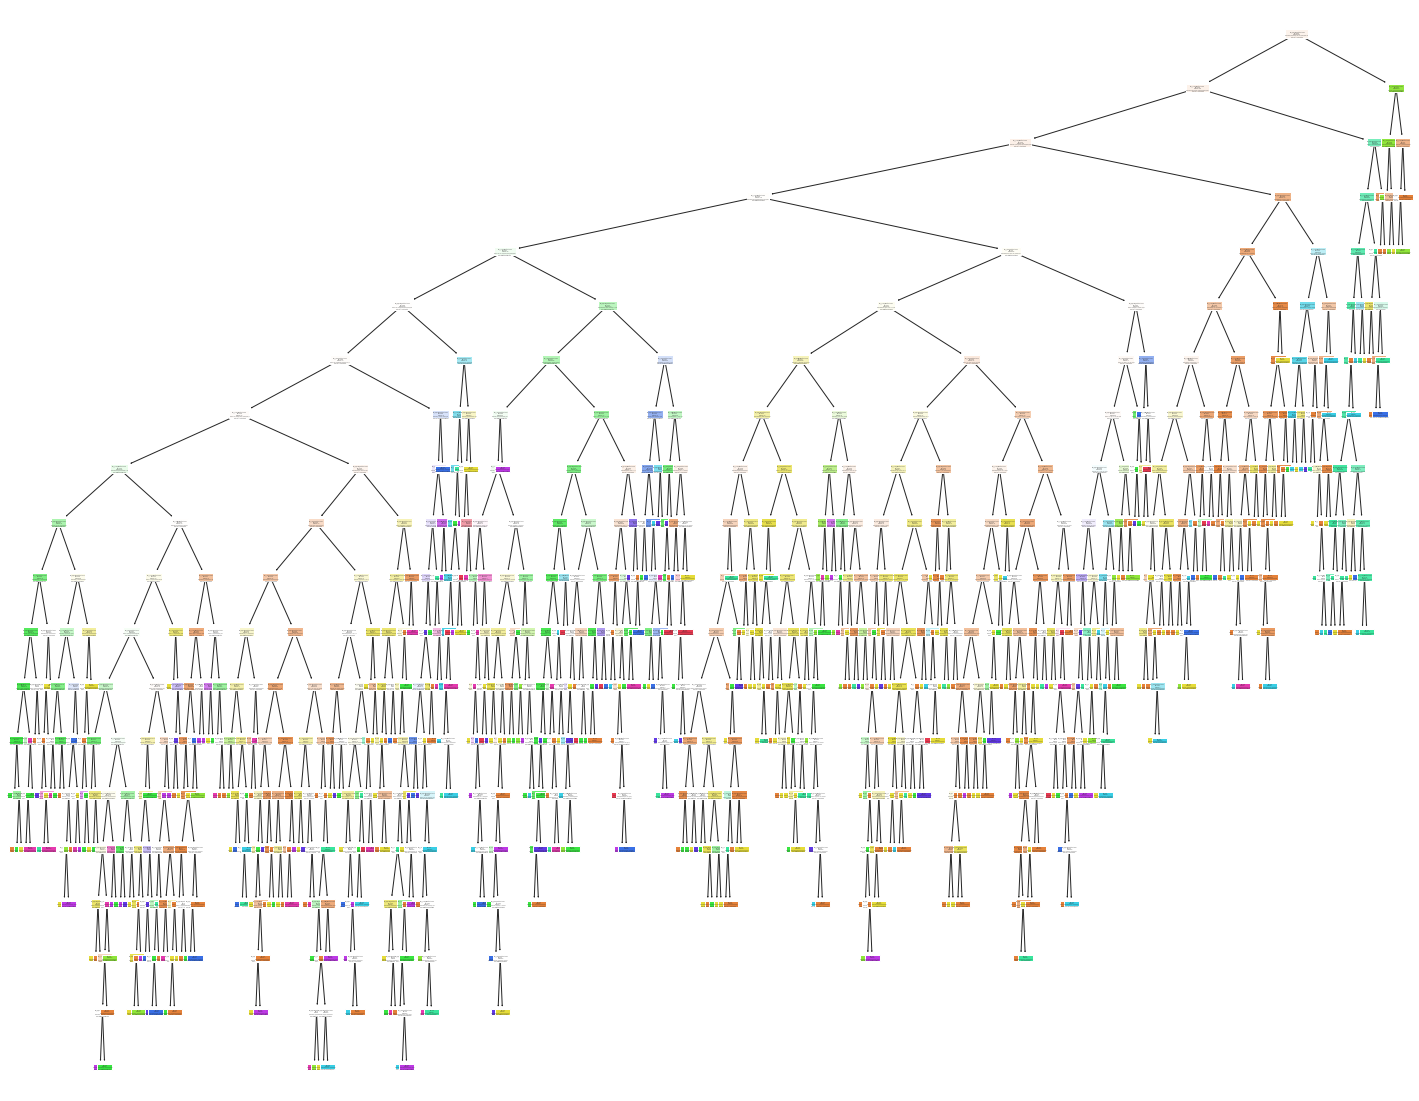

In [46]:
from sklearn import tree

#visual representation of tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc_one, 
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)


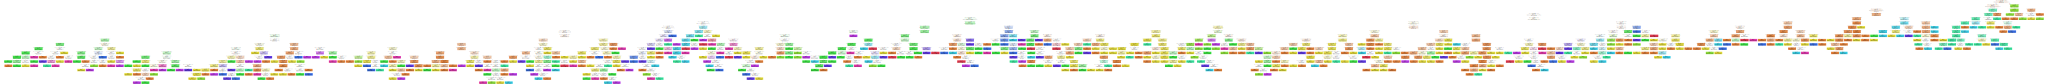

In [47]:
#better visualization
dot_data = tree.export_graphviz(dtc_one, out_file=None, feature_names=feature_names,  class_names=class_names, filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

In [48]:
X = dtc_result.drop('WeakLinks', axis=1)
y = dtc_result['WeakLinks']

trainingPercent = 0.8

dtc_X_train, dtc_X_test, dtc_y_train, dtc_y_test  = train_test_split(X, y, train_size = trainingPercent)

### 1

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

dtc_two = DecisionTreeClassifier()
dtc_two.fit(dtc_X_train, dtc_y_train)

dtc_y_pred_2 = dtc_two.predict(dtc_X_test)

#print(accuracy_score(dtc_y_test, dtc_y_pred_2))
#print(confusion_matrix(dtc_y_test, dtc_y_pred_2))
print(classification_report(dtc_y_test, dtc_y_pred_2))

              precision    recall  f1-score   support

           0       0.57      0.47      0.52       135
           1       0.34      0.34      0.34        94
           2       0.83      0.85      0.84        62
           3       0.33      0.38      0.36        50
           4       0.50      0.42      0.46        19
           5       0.40      0.44      0.42        18
           6       0.25      0.23      0.24        13
           7       0.09      0.10      0.10        10
           8       0.07      0.25      0.11         4
           9       0.15      0.20      0.17        10
          10       0.00      0.00      0.00         2

    accuracy                           0.46       417
   macro avg       0.32      0.34      0.32       417
weighted avg       0.48      0.46      0.47       417



In [50]:
# function for fitting trees of various depths on the training data using cross-validation
def run_cross_validation_on_trees(X, y, tree_depths, cv=10, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
  
# function for plotting cross-validation results
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()



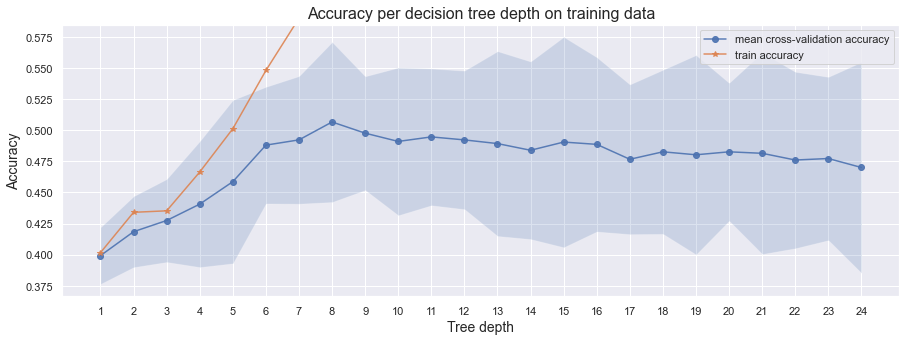

In [51]:
# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(dtc_X_train, dtc_y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')


In [52]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-8 tree achieves the best mean cross-validation accuracy 50.6594 +/- 3.21348% on training dataset


In [53]:
dtc_three = DecisionTreeClassifier(max_depth=sm_best_tree_depth)
dtc_three.fit(dtc_X_train, dtc_y_train)

dtc_y_pred_3 = dtc_three.predict(dtc_X_test)

#print(accuracy_score(dtc_y_test, dtc_y_pred_3))
#print(confusion_matrix(dtc_y_test, dtc_y_pred_3))
print(classification_report(dtc_y_test, dtc_y_pred_3))
accuracy_4 = classification_report(dtc_y_test, dtc_y_pred_3, digits=3,output_dict=True)["accuracy"]

              precision    recall  f1-score   support

           0       0.51      0.53      0.52       135
           1       0.33      0.34      0.33        94
           2       0.86      0.90      0.88        62
           3       0.31      0.52      0.39        50
           4       0.64      0.37      0.47        19
           5       0.70      0.39      0.50        18
           6       0.33      0.15      0.21        13
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         2

    accuracy                           0.48       417
   macro avg       0.33      0.29      0.30       417
weighted avg       0.47      0.48      0.47       417



                       Importance
No_2_Angle_Deviation     2.265479
No_3_Angle_Deviation     0.000000
No_4_Angle_Deviation     0.330408
No_6_Angle_Deviation     2.449261
No_8_Angle_Deviation     0.578214
No_9_Angle_Deviation     0.000000
No_11_Angle_Deviation    0.000000
No_12_Angle_Deviation    1.991107
No_2_NASM_Deviation      6.141630
No_3_NASM_Deviation      0.330408
No_4_NASM_Deviation      0.000000
No_6_NASM_Deviation      7.143968
No_7_NASM_Deviation     10.243958
No_8_NASM_Deviation     12.830597
No_10_NASM_Deviation    10.064596
No_12_NASM_Deviation    32.268526
No_13_NASM_Deviation     2.395824
No_14_NASM_Deviation     1.944409
No_15_NASM_Deviation     0.531013
No_16_NASM_Deviation     0.000000
No_17_NASM_Deviation     2.476859
No_18_NASM_Deviation     0.265506
No_19_NASM_Deviation     2.285838
No_20_NASM_Deviation     0.000000
No_21_NASM_Deviation     0.900413
No_22_NASM_Deviation     0.634265
No_23_NASM_Deviation     0.000000
No_24_NASM_Deviation     0.000000
No_25_NASM_Dev

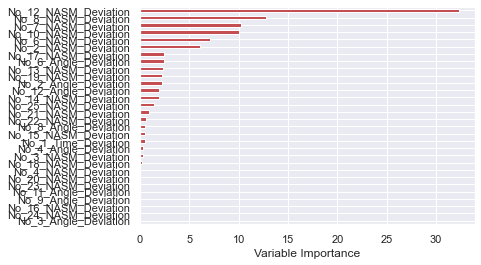

In [54]:
Importance = pd.DataFrame({'Importance':dtc_three.feature_importances_*100}, 
                          index = dtc_X_train.columns)
print(Importance)
Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )


plt.xlabel('Variable Importance')
plt.gca().legend_ = None

### 2

Tried using No_12_NASM_Deviation * No_12_NASM_Deviation

In [55]:
dtc_result_2 = result.drop(['AimoScore'], axis=1)
dtc_result_2['No_12_NASM_Deviation^2'] = dtc_result_2['No_12_NASM_Deviation'] * dtc_result_2['No_12_NASM_Deviation']
dtc_result_2['WeakLinks'] = dtc_result_2.WeakLinks.map({'LeftArmFallForward':0, 'RightArmFallForward':1, 'RightKneeMovesOutward':2, 'RightShoulderElevation':3, 'ForwardHead':4, 'ExcessiveForwardLean':5, 'LeftAsymmetricalWeightShift':6, 'LeftShoulderElevation':7, 'LeftKneeMovesOutward':8, 'RightKneeMovesInward':9, 'RightAsymmetricalWeightShift':10})

In [56]:
X = dtc_result_2.drop('WeakLinks', axis=1)
y = dtc_result_2['WeakLinks']

trainingPercent = 0.8

dtc_X_train, dtc_X_test, dtc_y_train, dtc_y_test  = train_test_split(X, y, train_size = trainingPercent)

In [57]:
dtc_four = DecisionTreeClassifier()
dtc_four.fit(dtc_X_train, dtc_y_train)

dtc_y_pred_4 = dtc_four.predict(dtc_X_test)

#print(accuracy_score(dtc_y_test, dtc_y_pred_4))
#print(confusion_matrix(dtc_y_test, dtc_y_pred_4))
print(classification_report(dtc_y_test, dtc_y_pred_4))

              precision    recall  f1-score   support

           0       0.55      0.49      0.52       130
           1       0.31      0.31      0.31        88
           2       0.93      0.87      0.90        71
           3       0.38      0.51      0.44        45
           4       0.57      0.67      0.62        18
           5       0.61      0.48      0.54        23
           6       0.40      0.40      0.40        10
           7       0.00      0.00      0.00         5
           8       0.17      0.22      0.19         9
           9       0.12      0.08      0.10        13
          10       0.00      0.00      0.00         5

    accuracy                           0.49       417
   macro avg       0.37      0.37      0.36       417
weighted avg       0.51      0.49      0.50       417



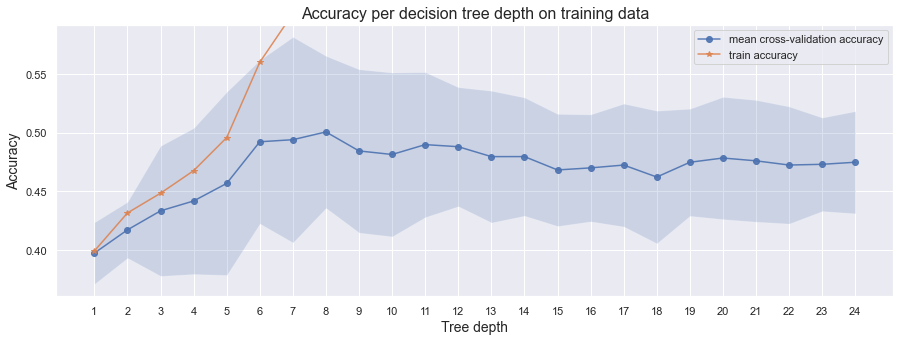

In [58]:
# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(dtc_X_train, dtc_y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                              'Accuracy per decision tree depth on training data')

In [59]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-8 tree achieves the best mean cross-validation accuracy 50.0606 +/- 3.23746% on training dataset


In [60]:
dtc_five = DecisionTreeClassifier(max_depth=sm_best_tree_depth)
dtc_five.fit(dtc_X_train, dtc_y_train)

dtc_y_pred_5 = dtc_five.predict(dtc_X_test)

#print(accuracy_score(dtc_y_test, dtc_y_pred_5))
#print(confusion_matrix(dtc_y_test, dtc_y_pred_5))
print(classification_report(dtc_y_test, dtc_y_pred_5))
accuracy_5 = classification_report(dtc_y_test, dtc_y_pred_5, digits=3,output_dict=True)["accuracy"]

              precision    recall  f1-score   support

           0       0.59      0.49      0.54       130
           1       0.33      0.50      0.40        88
           2       0.98      0.87      0.93        71
           3       0.33      0.58      0.42        45
           4       0.64      0.50      0.56        18
           5       0.69      0.39      0.50        23
           6       0.40      0.20      0.27        10
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         5

    accuracy                           0.52       417
   macro avg       0.36      0.32      0.33       417
weighted avg       0.53      0.52      0.51       417



### 3

Tried using No_12_NASM_Deviation * No_8_NASM_Deviation

In [61]:
dtc_result_3 = result.drop(['AimoScore'], axis=1)
dtc_result_3['No_12_NASM_Deviation_2_No_8_NASM_Deviation'] = dtc_result_3['No_12_NASM_Deviation'] * dtc_result_2['No_8_NASM_Deviation']
dtc_result_3['WeakLinks'] = dtc_result_3.WeakLinks.map({'LeftArmFallForward':0, 'RightArmFallForward':1, 'RightKneeMovesOutward':2, 'RightShoulderElevation':3, 'ForwardHead':4, 'ExcessiveForwardLean':5, 'LeftAsymmetricalWeightShift':6, 'LeftShoulderElevation':7, 'LeftKneeMovesOutward':8, 'RightKneeMovesInward':9, 'RightAsymmetricalWeightShift':10})

In [62]:
X = dtc_result_3.drop('WeakLinks', axis=1)
y = dtc_result_3['WeakLinks']

trainingPercent = 0.8

dtc_X_train, dtc_X_test, dtc_y_train, dtc_y_test  = train_test_split(X, y, train_size = trainingPercent)

In [63]:
dtc_six = DecisionTreeClassifier()
dtc_six.fit(dtc_X_train, dtc_y_train)

dtc_y_pred_6 = dtc_six.predict(dtc_X_test)

#print(accuracy_score(dtc_y_test, dtc_y_pred_6))
#print(confusion_matrix(dtc_y_test, dtc_y_pred_6))
print(classification_report(dtc_y_test, dtc_y_pred_6))

              precision    recall  f1-score   support

           0       0.53      0.50      0.52       119
           1       0.39      0.35      0.37        99
           2       0.85      0.82      0.84        62
           3       0.38      0.56      0.45        48
           4       0.57      0.60      0.59        20
           5       0.25      0.26      0.26        19
           6       0.30      0.27      0.29        11
           7       0.21      0.25      0.23        12
           8       0.17      0.18      0.17        11
           9       0.00      0.00      0.00        12
          10       0.00      0.00      0.00         4

    accuracy                           0.47       417
   macro avg       0.33      0.35      0.34       417
weighted avg       0.47      0.47      0.47       417



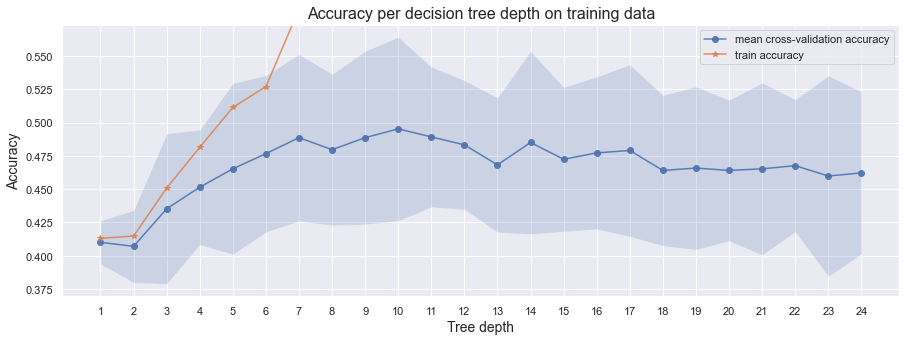

In [64]:
# fitting trees of depth 1 to 24
sm_tree_depths = range(1,25)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(dtc_X_train, dtc_y_train, sm_tree_depths)

# plotting accuracy
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                              'Accuracy per decision tree depth on training data')

In [65]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-10 tree achieves the best mean cross-validation accuracy 49.52457 +/- 3.45195% on training dataset


In [66]:
dtc_seven = DecisionTreeClassifier(max_depth=sm_best_tree_depth)
dtc_seven.fit(dtc_X_train, dtc_y_train)

dtc_y_pred_7 = dtc_seven.predict(dtc_X_test)

#print(accuracy_score(dtc_y_test, dtc_y_pred_7))
#print(confusion_matrix(dtc_y_test, dtc_y_pred_7))
print(classification_report(dtc_y_test, dtc_y_pred_7))

accuracy_6 = classification_report(dtc_y_test, dtc_y_pred_7, digits=3,output_dict=True)["accuracy"]

              precision    recall  f1-score   support

           0       0.47      0.59      0.52       119
           1       0.38      0.38      0.38        99
           2       0.93      0.82      0.87        62
           3       0.43      0.48      0.46        48
           4       0.69      0.55      0.61        20
           5       0.54      0.37      0.44        19
           6       0.45      0.45      0.45        11
           7       0.20      0.08      0.12        12
           8       0.20      0.09      0.13        11
           9       0.00      0.00      0.00        12
          10       0.00      0.00      0.00         4

    accuracy                           0.50       417
   macro avg       0.39      0.35      0.36       417
weighted avg       0.49      0.50      0.49       417



# Result Comparison

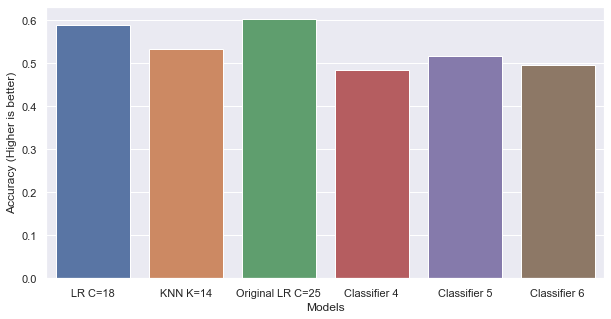

In [67]:
results = pd.DataFrame({"Accuracy":[accuracy_1,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6],"Models":["LR C=18","KNN K=14","Original LR C=25","Classifier 4","Classifier 5","Classifier 6"]})

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(data=results, x="Models", y="Accuracy",ax=ax)

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("Accuracy (Higher is better)")

plt.show()